# A SIMPLE PRINCIPLE EXAMPLE ON CONTEXT-SPECIFIC MODEL SELECTION

by Sebastian T. Glavind, Jan 2021, Apr 2021

# Introduction

This notebook shows how the numerical optimization is conducted in the example by the same name of the paper:

Glavind, S. T., Brüske, H., Christensen, E. D, and Faber, M. H., "On systems modeling and context-specific model selection in offshore engineering", submitted to Computer-Aided Civil and Infrastructure Engineering, 2021.

The paper is currently under review. A link to the paper with a description of the example will follow, when the paper is accepted for publication.


# Prelude

In [2]:
# library(MCMCpack)
# library(foreach)
# library(doParallel) 

# Data

## Concrete data

### Raw data

Sampling of compression data (log-normal distribution)

In [3]:
# real to log quantities
Parameters_real2log = function(mu,sd){
    muLog = log( mu^2/( sqrt(mu^2 + sd^2) ) ); 
    sdLog = sqrt( log( 1 + (sd^2)/(mu^2) ) )
    return(list(muLog, sdLog))
}

In [4]:
set.seed(42)

# Concrete compressiv strength
muZ = 32.665; sdZ = 4.15; nZ = 1000
pamZlog = Parameters_real2log(muZ, sdZ); 
muZlog = pamZlog[[1]]; sdZlog = pamZlog[[2]]
zc = exp(rnorm(nZ, mean=muZlog, sd=sdZlog)); 

### Discrete data

Upper and lower bound for the discretization;

In [5]:
eps = 1e-6
BP_bounds = c(min(zc)-eps, max(zc)+eps);

## Load distribution

In [6]:
# Load distribution
muL = 200; CoV_L = 0.2; sdL = muL*CoV_L;  
pamLlog = Parameters_real2log(muL, sdL); 
muLlog = pamLlog[[1]]; sdLlog = pamLlog[[2]]

# Plot
xaxStress_plot = seq(0,50,length=100); a_plot = 12
pamStress_plot = Parameters_real2log(muL/a_plot, sdL/a_plot); # I think that sdL is not scaled correctly!!! (but this anly influence thus illustration - so dont worry)
densStress_plot = dlnorm(xaxStress_plot, meanlog = pamStress_plot[[1]], sdlog = pamStress_plot[[2]])

## Visualizations

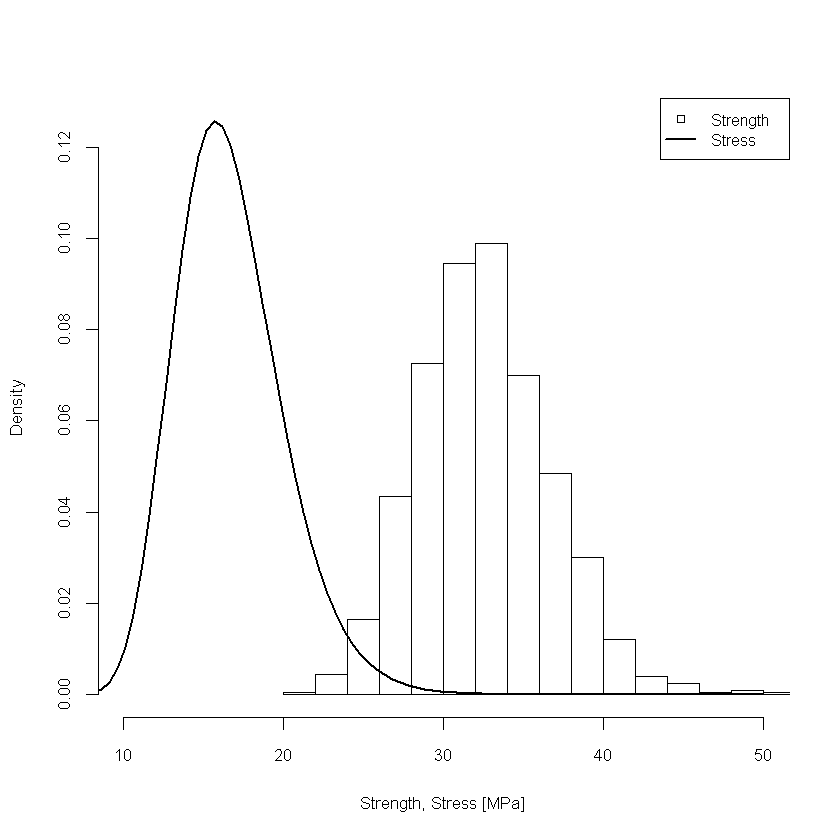

In [7]:
# # Open a pdf file
# pdf("simpleExample_distributions.pdf", width=5, height=5) 
# Create a plot
Hinit=hist(zc, freq=F, xlim = c(10,50), ylim=c(0,max(densStress_plot)), xlab='Strength, Stress [MPa]', main='', cex.lab=0.85, cex.axis=0.85) # initial discretization for illustartion purposes only
lines(xaxStress_plot, densStress_plot, lw=2)
legend("topright", legend=c("Strength", "Stress"), col=c("black", "black"), lw=c(NA,2), lty = c(NA,1), pch = c(0, NA), cex=0.8)
# # Close the pdf file
# dev.off() 

# Optimization problem

$$ \min_A [C_p(A) + C_f(A)] = \min_A [C_p \cdot A + C_f \cdot P_f(A)] = \min_A [C_p \cdot A + C_f \cdot P(\{A \cdot Z - l \leq 0\})] $$

## Cost functions

In [8]:
########################################################################
# PROBABILITY OF FAILURE FOR COST FUNCTIONS
########################################################################
# Frequentistic implementation
Pf_eval_data = function(Area, Load, distZ){
    bpZ = distZ$breaks; # print(bpZ) # boundery points (same as BP_list)
    denZ = distZ$density; # print(distZ$counts) # densities
    ratio = Load/Area; # print(ratio) # Load per area
    if (ratio < bpZ[1]){
        Pf = 0
    } else if (bpZ[length(bpZ)] < ratio){
        Pf = 1
    } else {
        if (sum(ratio == bpZ)>0){ # correstion if ratio coincide with boundery point
            ratio = ratio + 1e-6
        }
        bp_min = max(bpZ[bpZ<ratio]); # print(bp_min) # lower bound of bin where ration fall
        bp_max = min(bpZ[bpZ>ratio]); # print(bp_max) # upper bound of bin where ration fall
        bpZact = bpZ[ bpZ<=bp_max ]; # print(bpZact) # active boundery points
        binsZact = bpZact[-1] - bpZact[-length(bpZact)]; # print(binsZact) # active bins
        binsZweight = rep(1,length(binsZact)); # print(binsZweight) # weight of each bin (initialization)
        binsZweight[length(binsZweight)] = (ratio-bp_min)/(bp_max-bp_min); # print(binsZweight) # ajust weight of last bin, i.e. bin where ratio fall
        denZact = denZ[c(1:length(binsZweight))]; # print(denZact) # weighted densities
        pi = binsZact*(binsZweight*denZact); # print(pi) # weighted bin probabilities
        Pf = sum(pi); # print(Pf) # probability of failure, i.e. P(Z <= ratio)
    }
    return(Pf)
}
# Bayesian implementation
dirichlet_sampler = function(nSamp, alpha_vec, seed=NULL){
    set.seed(seed) # iff NULL; generate random seed
    nAlp = length(alpha_vec)
    y_gam_mat = matrix(1, nrow=nSamp, ncol=nAlp)
    for (i in 1:nAlp){
         y_gam_mat[,i] = rgamma(nSamp, alpha_vec[i]) 
    }
    y_dir_mat =  y_gam_mat/rowSums(y_gam_mat); # print(colSums(y_gam_mat))
    return(y_dir_mat)
}
Pf_eval = function(Area, Load, distZ, nSamp=100, seed=NULL){
    bpZ = distZ$breaks; # print(bpZ) # boundery points (same as BP_list)
    ratio = Load/Area; # print(ratio) # Load per area
    if (ratio < bpZ[1]){
        Pf = 0
    } else if (bpZ[length(bpZ)] < ratio){
        Pf = 1
    } else {
        if (sum(ratio == bpZ)>0){ # correstion if ratio coincide with boundery point
            ratio = ratio + 1e-6
        }
        bp_min = max(bpZ[bpZ<ratio]); # print(bp_min) # lower bound of bin where ration fall
        bp_max = min(bpZ[bpZ>ratio]); # print(bp_max) # upper bound of bin where ration fall
        bpZact = bpZ[ bpZ<=bp_max ]; # print(bpZact) # active boundery points
        binsZact = bpZact[-1] - bpZact[-length(bpZact)]; # print(binsZact) # active bins
        binsZweight = rep(1,length(binsZact)); # print(binsZweight) # weight of each bin (initialization)
        binsZweight[length(binsZweight)] = (ratio-bp_min)/(bp_max-bp_min); # print(paste0('w = ',binsZweight)) # ajust weight of last bin, i.e. bin where ratio fall
        # Bayesian implementation
        countsZ = distZ$counts; # print(countsZ) # empirical counts
        denZsamp = dirichlet_sampler(nSamp, countsZ+1, seed); # print(denZsamp[c(1:10),]) # empirical counts + prior counts (1)
#         denZsamp = rdirichlet(n = nSamp, alpha=countsZ+1) # function from MCMCpack
        denZsamp_act = denZsamp[ , c(1:length(binsZweight))]; # print(denZact) # weighted densities
        if (class(denZsamp_act)=='numeric'){ # its a vector (one active bin)
            Pf = denZsamp_act*binsZweight; # probability of failure, i.e. P(Z <= ratio)
        } else {
            Pf = denZsamp_act%*%binsZweight; # probability of failure, i.e. P(Z <= ratio)
        }
    }
    return(Pf)
}
########################################################################
# COST FUNCTIONS
########################################################################
Cp_eval = function(Area,Cp){
    Cost = Cp * Area
    return(Cost)
}
Cf_eval = function(Pf,Cf){
    Cost = Cf * Pf
    if (length(Cost)>1){
        Cost = mean(Cost) # expected cost
    }
    return(Cost)
}
# Frequentistic implementation
Ctotal_eval_data = function(Area, Load, distZ, Cp, Cf){
    Pf = Pf_eval_data(Area, Load, distZ)
    Cf_total = Cf_eval(Pf, Cf)
    Cp_total = Cp_eval(Area, Cp)
    Ctotal = Cf_total + Cp_total
    return(Ctotal)
}
# Bayesian implementation
Ctotal_eval = function(Area, Load, distZ, Cp, Cf, nSamp = 100, seed=NULL){
    Pf = Pf_eval(Area, Load, distZ, nSamp, seed); 
    Cf_total = Cf_eval(Pf, Cf); 
    Cp_total = Cp_eval(Area, Cp);
    Ctotal = Cf_total + Cp_total
    return(Ctotal)
}

# # test
# PPf=Pf_eval(10, 234, Hinit, nSamp=100, seed=NULL); # PPf
# hist(PPf)
# print(paste0('Empirical value: ', sum(zc<234/10)/length(zc)))

# CCtest = Ctotal_eval(10, 234, Hinit, 1, 100, nSamp = 100, seed=NULL); CCtest
# hist(CCtest)

## Discretization functions

### Discretize capacity

Adapted from `sLearningAndDiscretizationTools` ( a toolbox developed by the first author, which is found at [link](https://github.com/SebastianGlavind/PhD-study/blob/master/Bayesian-networks/Toolboxes/sLearningAndDiscretizationTools.R)).

In [9]:
discretize_oneVariable = function(data, BP_bounds, quiet, n_iterations_max = NULL, Area, Load, Cp, Cf, nSamp=100, seed=NULL){
  
    sort_data = sort(unique(data)); # print(sort_data) # sort, unique continuous data instances
    n_uniq = length(sort_data); # print(n_uniq) # no. of unique continuous data instances
    BP_i = (sort_data[-n_uniq] + sort_data[-1])/2; # print(length(BP_i)) # Initial set of potential boundery points (BP)
    if (length(BP_i)>512){
      BP_i = sort(sample(BP_i, 512, replace = FALSE, prob = NULL)); # Reduces the number of trial points
    }; # print(length(BP_i))
    BP_list_i = BP_bounds; # print(BP_list_i) # Initial list of BP 
    
    # Iteration for optimal discretization
    n_iterations = 0 # initialize number of iterations
    if (is.null(n_iterations_max)){ # maximum number of iterations (default) 
      ###################################
      if (round((n_uniq-1)/10) < 10){
        n_iterations_max = n_uniq-1 # min 10, but else ...
      } else {
        n_iterations_max = round((n_uniq-1)/10); # max 1/10 of potential BP
      }
      ###################################
    } else {
      ###################################
      n_iterations_max = n_iterations_max
      ###################################
    } # //*IF, ELSE*//
    
    
    score_i = -Inf # Initialize reference score (iteration n_iter-1)
    score_i_new = -10^5 # Initialize new score
    
    while ((score_i - score_i_new < 0)&(n_iterations < n_iterations_max)) {
    # while ((n_iterations < n_iterations_max)) {
      # print(score_i); print(score_i_new)
      n_iterations = n_iterations + 1; 
      
      if (quiet == FALSE){
        # print(c('Max_it',n_iterations_max)) 
        print('Ite'); print(n_iterations) # Number of iterations 
      } # //*IF*//
      
      # Updating
      if (n_iterations > 1){
        BP_i = BP_i_new
        BP_list_i = BP_list_i_new
        score_i = score_i_new 
      }
      
      # Loop over current set of potential BP
      score_ij_new = -Inf
      for (j in 1:length(BP_i)){ # Loop over boundery points (BP)   
        BP_list_ij_test = sort(c(BP_list_i, BP_i[j])); # print(BP_list_ij_test) # add new candidate point j to list of BP
        
        ########################################################################################
        # CUSTOM OBJECTIVE
        ########################################################################################
        hist_ij_obj = hist(data, breaks = BP_list_ij_test, plot=F)
        score_ij = - Ctotal_eval(Area, Load, hist_ij_obj, Cp, Cf, nSamp, seed); # print(score_ij) # negative cost in maximization!
        ########################################################################################
        # Update, iff score is improved compared to privious best candidate point
        if (score_ij > score_ij_new){ # Update, if the is an inprovenemt from privious trial
          index_ij_new = j # index of (current) best candidate point 
          BP_list_ij_new = BP_list_ij_test # new list of BP including this point
          score_ij_new = score_ij # new score
          # print(score_ij_new)
        } # //*IF*//
      } # //*FOR, j*//
      
      # Updating/book keeping
      BP_i_new = BP_i[-index_ij_new] # new list of candidate BP (exclude the one accepted in this iteration)  
      BP_list_i_new = BP_list_ij_new # new list of BP
      score_i_new = score_ij_new; # print(score_i_new) # new score
    }
    ###################################
    # Update discrete data
    if (n_iterations==n_iterations_max){
      BP_list = BP_list_i_new; # not cenverged  - choose last update! - ie. best possible score
      score = score_i_new;
    } else{
      BP_list = BP_list_i; # converged - choose the minimum number of splits (one more reduces the score) - ie. best possible score
      score = score_i;
    }
    ###################################
  return(list(BP_list = BP_list, score=score))
} # //*FUNCTION*//

# test
# res2 = discretize_oneVariable(data=zc, BP_bounds=BP_bounds, quiet=F, n_iterations_max = NULL, Area=10, Load=260, Cp=1, Cf=100)
# print('Results for scenario 2')
# print(res2$score)
# print(res2$BP_list)
# distZ2 = hist(zc, breaks = res2$BP_list)

### Discretize load

In [10]:
equal_width_logNorm_discretizer = function(lwX, upX, nBins, muLog, sdLog){
    rangeX = upX - lwX;
    dx = rangeX/nBins
    bps = lwX + c(0:nBins)*dx;
    mids = (bps[-1] + bps[-(nBins+1)])/2
    dens = dlnorm(mids, muLog, sdLog)
    return(list(bps, mids, dens))
}

create_custom_histObj = function(breaks, counts, density, mids, xname){
    histres <- list(
        breaks=breaks,
        counts=counts,
        density=density,
        mids=mids,
        xname=xname,
        equidist = TRUE
    )
    class(histres) <- "histogram"
    return(histres)
} 

plot_loading_systems = function(boundsL, muLlog, sdLlog, discL){
    xaxL_plot = seq(boundsL[1],boundsL[2],length=100);
    densL_plot = dlnorm(xaxL_plot, meanlog = muLlog, sdlog = sdLlog)
    plot(xaxL_plot, densL_plot, type="l", col="gray", xlab='Load', ylab='Density', main='Loading systems')
    plot(create_custom_histObj(discL[[1]], discL[[3]], discL[[3]], discL[[2]], 'Load'), freq=F, add=T)
    for (k in 1:length(discL[[2]])){
        lines(rep(discL[[2]][k],2), c(0,discL[[3]][k]), lw=2, col='red')
        text(discL[[2]][k], discL[[3]][k], paste0('Load = ', round(discL[[2]][k],0)))
    }   
}

# # test
# # Discrete density
# bounds_test = qlnorm(c(0.001, 0.999), muLlog, sdLlog); # bounds_test 
# res_test = equal_width_logNorm_discretizer(bounds_test[1], bounds_test[2], 5, muLlog, sdLlog); # res_test
# # sum(res_test[[3]]*(res_test[[1]][2]-res_test[[1]][1]))
# myHistObj_test = create_custom_histObj(res_test[[1]], res_test[[3]], res_test[[3]], res_test[[2]], 'test')
# # True continuous density
# xaxL_plot = seq(100,350,length=100);
# densL_plot = dlnorm(xaxL_plot, meanlog = muLlog, sdlog = sdLlog)
# # Plot
# plot(myHistObj_test, freq=F, main='')
# lines(xaxL_plot, densL_plot, lw=2)

## Area optimizer

### Continuous

In [11]:
gen_random_seed = function(lw,up){
    seed = as.integer((up-lw) * runif(1) + lw)
    return(seed)
}

numerical_gradient = function(Area, Load, distZ, Cp, Cf, nSamp=100, seed=1){
    ee = 1e-6 * Area
    Area_lw = Area - ee
    Area_hi = Area + ee
    dCdA = ( Ctotal_eval(Area_hi, Load, distZ, Cp, Cf, nSamp, seed) - Ctotal_eval(Area_lw, Load, distZ, Cp, Cf, nSamp, seed) )/(2*ee)
    if (abs(dCdA)>1){
        dCdA = sign(1)
    }
    return(dCdA)
}

optimize_area = function(Area, Load, distZ, Cp, Cf, z, nSamp=100){
    gamma = 1
    precision = 1e-3
    max_epochs = 1000
    rangeZ = range(z)
    rangeA = Load/rangeZ; print(rangeA)
    seed = gen_random_seed(0,2147483647) # up = .Machine$integer.max
    for (k in c(1:max_epochs)){
#         print(k); print(Area)
        gamma = gamma * exp(-0.001*(k-1)); # print(gamma) # temporing
        dCdA = numerical_gradient(Area, Load, distZ, Cp, Cf, nSamp, seed)
        Area_new = Area - gamma * dCdA # minimize cost!
        if (Area_new < rangeA[2]){
            Area = rangeA[2] + precision  
            break
        }
        if (Area_new > rangeA[1]){
            Area = rangeA[1] - precision
            break
        }
        if (abs((Area_new-Area)/Area) < precision){
            Area = Area_new
            break
        }
        ##############################################
        # Updata for next iteration
        ##############################################
        Area = Area_new
        print(Area)
        ##############################################
    }
    return(Area)
}
# test
# optimize_area(Area=10, Load=260, distZ=distZ2, Cp=1, Cf=100, z=zc)

# validation
# A_test = seq(from=260/max(zc), to = 260/min(zc), by=0.01)
# Aopt_vec = list()
# for (k in 1:length(A_test)){
#     Aopt_vec[[k]] = Ctotal_eval(A_test[k], 260, distZ_test, 1, 100)    
# }
# min(unlist(Aopt_vec))

## Optimize Area and discretization

### Continuous

In [12]:
optAreaAndDiscretization = function(Area, Area_bounds, Load, Cp, Cf, z, BP_bounds, nSamp=100, seed=NULL){
    cost = 1e6
    precision = 1e-3
    max_epochs = 1000
    Area = mean(Area_bounds)
    for (k in c(1:max_epochs)){
#         print(paste0('k = ', k))
        res = discretize_oneVariable(data=zc, BP_bounds=BP_bounds, quiet=T, n_iterations_max = NULL, Area=Area, Load=Load, Cp=Cp, Cf=Cf, nSamp=nSamp, seed=seed)
        BP_list = res$BP_list # print(BP_list)
        distZ = hist(zc, breaks = BP_list, plot=F)
        # Area = optimize_area(Area=Area, Load=Load, distZ=distZ, Cp=Cp, Cf=Cf, z=zc, nSamp); # print(Area)
        # cost_new = Ctotal_eval(Area, Load, distZ, Cp, Cf, nSamp, seed)
        optArea = optimize(Ctotal_eval, Area_bounds, tol=1e-4, Load=Load, distZ=distZ, Cp=Cp, Cf=Cf, nSamp=nSamp, seed=gen_random_seed(0,2147483647))
        Area = optArea$minimum
        cost_new = optArea$objective
#         print(paste0('Area = ', Area, ', cost = ', cost_new))
        if ( abs(cost_new-cost)/cost < precision){
            break
        } else {
            cost = cost_new
        }
    }
    return(list(BP_list=BP_list, distZ=distZ, Area=Area, cost=cost))
}

### Discrete

In [13]:
optAreaAndDiscretization_discrete = function(Avec, Load, Cp, Cf, z, BP_bounds, nSamp=100, seed=NULL){
    nA = length(Avec)
    cost = Inf
    for (k in 1:nA){
        res = discretize_oneVariable(data=zc, BP_bounds=BP_bounds, quiet=T, n_iterations_max = NULL, Area=Avec[k], Load=Load, Cp=Cp, Cf=Cf, nSamp, seed)
        BP_list_new = res$BP_list
        distZ_new = hist(zc, breaks = BP_list_new, plot=F)
        cost_new = Ctotal_eval(Avec[k], Load, distZ_new, Cp, Cf, nSamp, seed)  
        if (cost_new < cost){
            cost = cost_new
            Area = Avec[k]
            BP_list = BP_list_new
            distZ = distZ_new
        }
        # print(list(cost,Area))            
    }
    return(list(BP_list=BP_list, distZ=distZ, Area=Area, cost=cost))
}

## Solve the optimization problem for a fixed load

### Continuous/Discrete

In [14]:
# set.seed(1)
# Area_bounds = c(6,16)
# # Avec = seq(from=10, to = 16, by=1)
# Load=234 # needs to be in the range of the data, such that Load/Area \in range(z)
# Cp=1
# Cf=100

# RES=optAreaAndDiscretization(Area_bounds=Area_bounds, Load=Load, Cp=Cp, Cf=Cf, z=zc, BP_bounds=BP_bounds, nSamp=1000, seed=NULL)
# nSim = 100
# cl = makeCluster(detectCores()-1)
# registerDoParallel(cl)
# RESsim = foreach(i=1:nSim) %dopar% {
#     optAreaAndDiscretization(Area_bounds=Area_bounds, Load=Load, Cp=Cp, Cf=Cf, z=zc, BP_bounds=BP_bounds, nSamp=1000, seed=NULL)
# }

In [15]:
# # RES

# print('Area'); print(RES$Area)
# plot(RES$distZ, main='Discrete representation')
# print('Total cost')
# print(RES$cost)

In [16]:
# cost_vec = c()
# for (k in 1:nSim){
# #     cost_vec = c(cost_vec, RESsim[[k]]$cost)
#     cost_vec = c(cost_vec, Ctotal_eval_data(RESsim[[k]]$Area, Load=Load, RESsim[[k]]$distZ, Cp=Cp, Cf=Cf))
# }
# # hist(cost_vec)
# optIndex = which.min(cost_vec)

# optRES = RESsim[[optIndex]]
# print('Area'); print(optRES$Area)
# print('Total cost')
# # print(optRES$cost)
# print(cost_vec[optIndex])
# plot(optRES$distZ, main='Discrete representation')
# # hist(zc, optRES$BP_list, main='Discrete representation')

## Solve the optimization problem for loading systems

In [17]:
# Initialize iterations
initialize_joint_iteration = function(loads_pri, dxLv_pri, dens_pri, optSys_index, nBinsL, muLlog, sdLlog, plot=TRUE){
    repSys_index = ceiling(nBinsL/2) # middle value of new discretization corr. to previous optimal system
    boundsL = loads_pri[optSys_index] + c(-1,1)*dxLv_pri[optSys_index]/2
    discL = equal_width_logNorm_discretizer(boundsL[1], boundsL[2], nBinsL, muLlog, sdLlog)
    new_loads = discL[[2]][-repSys_index]
    loads_pos = c(loads_pri, new_loads)
    dxL_pos = discL[[2]][2] - discL[[2]][1]
    dxLv_pos = dxLv_pri; dxLv_pos[optSys_index] = dxL_pos; dxLv_pos = c(dxLv_pos, rep(dxL_pos,nBinsL-1)) 
    dens_pos = dens_pri; dens_pos[optSys_index] = discL[[3]][repSys_index]/nBinsL; dens_pos = c(dens_pos, discL[[3]][-repSys_index]/nBinsL) # accounting for bin with reduction (w_pos=w_pri/nBins)
    weights_pos = dens_pos/sum(dens_pos)
    
    if (plot==TRUE){
        # Plot
        plot_loading_systems(boundsL=boundsL, muLlog=muLlog, sdLlog=sdLlog, discL=discL)
    }
    
    return(list(loads_pos=loads_pos, new_loads=new_loads, dxLv_pos=dxLv_pos, dens_pos=dens_pos, weights_pos=weights_pos))
}

# Compute and include new systems in systems list
updata_sysReps_list = function(sysReps_pri, new_loads, nSamp=100, seed=NULL){
    sysReps_pos = sysReps_pri # initialize new object
    nSys_pri = length(sysReps_pri)
    for (s in 1:length(new_loads)){
        sysReps_pos[[nSys_pri + s]] = optAreaAndDiscretization(Area_bounds=Area_bounds, Load=new_loads[s], Cp=Cp, Cf=Cf, z=zc, BP_bounds=BP_bounds, nSamp=1000, seed=NULL)
    }
    return(sysReps_pos)
}

# Compute expected utility over system choice and design (Area and discretization for capacity) 
compute_cost_avg_over_systems_choices = function(loads, weights, sysReps){
    costs = c()
    for (i in c(1:length(loads))){
        temp = c()
        for (j in c(1:length(loads))){
            temp = c(temp, Ctotal_eval_data(sysReps[[i]]$Area, loads[j], sysReps[[i]]$distZ, Cp, Cf) )
        }
        costs = c(costs, weights%*%temp)
    }
    return(costs)
}

# Plot optimal sys. rep. (Area and capacity) along with system choice (load)
plot_optSysRep_capacity = function(sysReps, loads, Optsys_index, costs){
    plot(sysReps[[Optsys_index]]$distZ, main=paste0('Load = ', round(loads[Optsys_index],0), ', Area = ', round(sysReps[[Optsys_index]]$Area,3), 
                                              ', Stress = ', round(loads[Optsys_index]/sysReps[[Optsys_index]]$Area,3), 
                                              ', Cost = ', round(costs[Optsys_index],3) ))
    points(c(loads[Optsys_index]/sysReps[[Optsys_index]]$Area),c(0), lw=5, col='red', pch=2)    
}

# Joint optimization of load, area and discretization of capacity
joint_optimization = function(loads_pos, dxLv_pos, dens_pos, weights_pos, nBinsL, muLlog, sdLlog, plot=TRUE, n_iterations_max=10, nSamp=100, seed=NULL){
    
    for (i in 1:n_iterations_max){
        
        if (i == 1){
            RES_pos = list() # initialize sys. rep. for capacity
            new_loads = loads_pos
        } else {
            init = initialize_joint_iteration(loads_pri=loads_pos, dxLv_pri=dxLv_pos, dens_pri=dens_pos, optSys_index, nBinsL, muLlog, sdLlog, plot=plot)
            new_loads = init$new_loads; 
            if ( length(unique(round(new_loads)))==1 ){ # terminate iteration if the new_loads rounds to the same integer 
                break
            }
            loads_pos = init$loads_pos; dxLv_pos = init$dxLv_pos
            dens_pos = init$dens_pos; weights_pos = init$weights_pos
        }
        
        RES_pos = updata_sysReps_list(sysReps_pri=RES_pos, new_loads=new_loads, nSamp, seed)
        costs_pos = compute_cost_avg_over_systems_choices(loads_pos, weights_pos, RES_pos)
        optSys_index = which.min(costs_pos)

        if (plot==TRUE){
            # Plot resulting sys. rep. 
            plot_optSysRep_capacity(RES_pos, loads_pos, optSys_index, costs_pos)    
        }
    }
    return(list(loads_pos=loads_pos, dxLv_pos=dxLv_pos, dens_pos=dens_pos, weights_pos=weights_pos, RES_pos=RES_pos, costs_pos=costs_pos, optSys_index=optSys_index))
}

In [18]:
set.seed(1)
Area_bounds = c(6,16)
Cp=1
Cf=100

### Optimization

#### Initialization

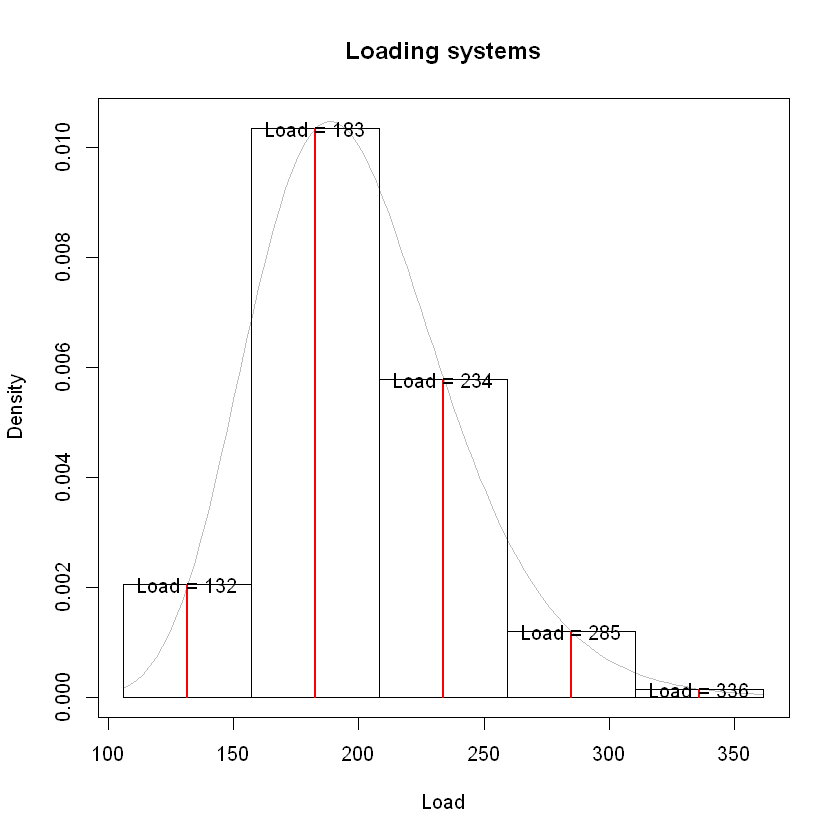

In [19]:
# Initial loading systems
nBinsL = 5 # choose as odd
boundsL0 = qlnorm(c(0.001, 0.999), muLlog, sdLlog); # bounds_test 
discL0 = equal_width_logNorm_discretizer(boundsL0[1], boundsL0[2], nBinsL, muLlog, sdLlog); # res_test
loads0 = discL0[[2]]
dxL0v = rep(loads0[2] - loads0[1], nBinsL) 
dens0 = discL0[[3]]
weights0 = dens0/sum(dens0)

# Plot
plot_loading_systems(boundsL=boundsL0, muLlog=muLlog, sdLlog=sdLlog, discL=discL0)

#### Run the optimization

In [20]:
# RES=joint_optimization(loads_pos=loads0, dxLv_pos=dxL0v, dens_pos=dens0, weights_pos=weights0, nBinsL, muLlog, sdLlog, 
#                        plot=TRUE, n_iterations_max=10, nSamp=1000, seed=NULL)

# nSim = 1000
# cl = makeCluster(detectCores()-1)
# registerDoParallel(cl)
# RESsim = foreach(i=1:nSim) %dopar% {
#     joint_optimization(loads_pos=loads0, dxLv_pos=dxL0v, dens_pos=dens0, weights_pos=weights0, nBinsL, muLlog, sdLlog, 
#                        plot=FALSE, n_iterations_max=10, nSamp=1000, seed=NULL)
# }
# save(RESsim, file='RESsim_LoadingAndCapacitySystem.rda')
# save(RESsim, file='RESsim_LoadingAndCapacitySystem1000.rda')

# load('RESsim_LoadingAndCapacitySystem.rda')
load('RESsim_LoadingAndCapacitySystem1000.rda')

#### Results

In [21]:
# RES

# Minimum cost considerations
# cost_vec = c()
# for (k in 1:length(RESsim)){
#     cost_vec = c(cost_vec, RESsim[[k]]$costs_pos[RESsim[[k]]$optSys_index])
# }
# hist(cost_vec)
# optIndex = which.min(cost_vec)

# Competing systems considerations
loads_vec = c()
weights_vec = c()
RES_list = list()
for (k in 1:length(RESsim)){
    optInd_k = RESsim[[k]]$optSys_index
    loads_vec = c(loads_vec, RESsim[[k]]$loads_pos[optInd_k])
    weights_vec = c(weights_vec, RESsim[[k]]$dens_pos[optInd_k]*RESsim[[k]]$dxLv_pos[optInd_k])
    RES_list[[k]] = RESsim[[k]]$RES_pos[[optInd_k]]
}
weights_vec = weights_vec/sum(weights_vec) # normalize weights
costs_vec = compute_cost_avg_over_systems_choices(loads_vec, weights_vec, RES_list)

##### Optimal model formulation

In [27]:
# Optimal solution to the decision problem (Note that cost is shown as average over the competing systems)
optIndex = which.min(costs_vec)
optRES = RES_list[[optIndex]]

# optRES

#### Plots and quantities for paper

In [31]:
# Cost acc. sample data (this system only - not considering the competing systems)
# optCost_data = Ctotal_eval_data(optRES$Area, loads_vec[optIndex], optRES$distZ, Cp, Cf); # optCost_data

# Expected cost (this system only - not considering the competing systems)
optCost = Ctotal_eval(optRES$Area, loads_vec[optIndex], optRES$distZ, Cp, Cf, nSamp=1000000, seed=NULL); 

print( paste0('Optimal area: ', round(optRES$Area,2) ) )
print( paste0('Optimal load: ', round(loads_vec[optIndex],0) ) )
print( paste0('Expected failure cost: ', round(optCost,2) ) ) # a little heigher than the the empirical estimate above due to the uniform prior (1)

[1] "Optimal area: 10.89"
[1] "Optimal load: 257"
[1] "Expected failure cost: 11.68"


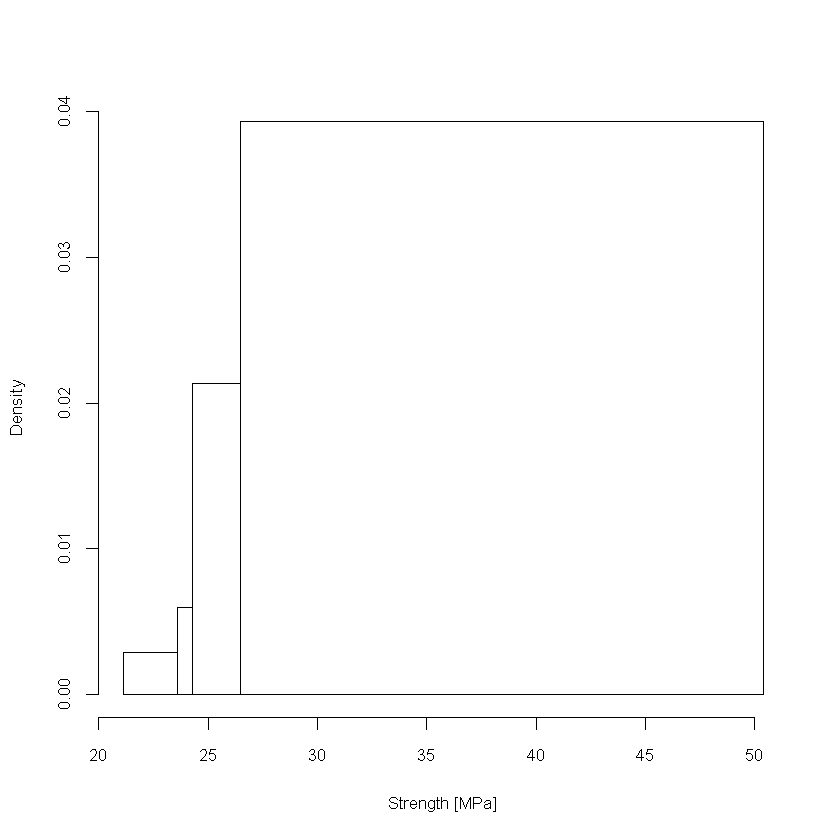

In [29]:
# Capacity model
# # Open a pdf file
# pdf("simpleExample_distZ_opt.pdf", width=5, height=5) 
# Create a plot
plot(optRES$distZ, main='', xlab='Strength [MPa]', cex.lab=0.85, cex.axis=0.85)
# # Close the pdf file
# dev.off() 

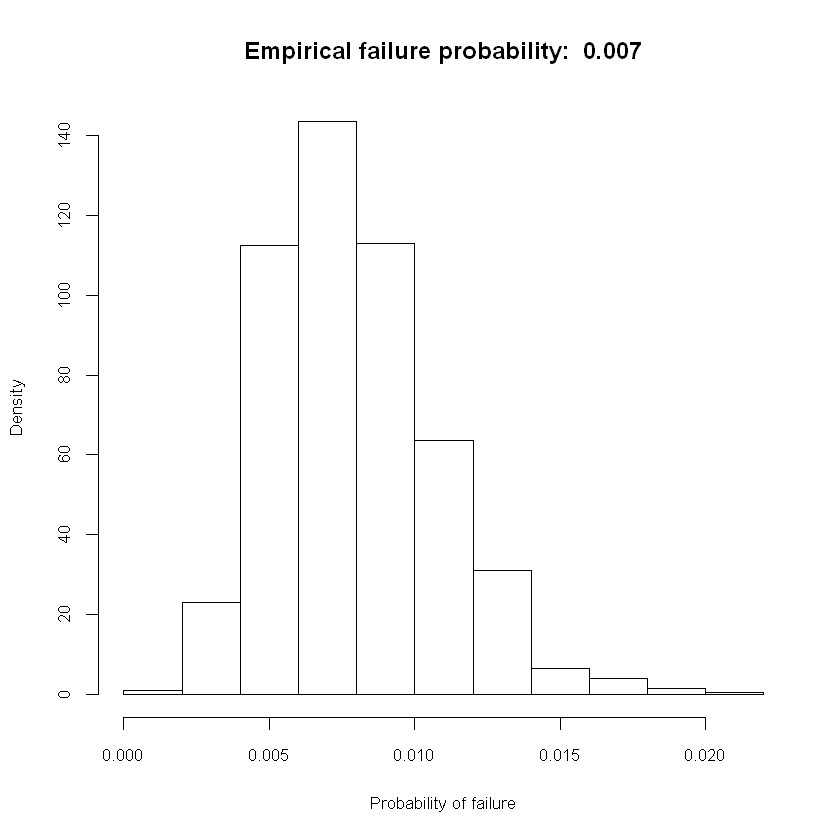

In [25]:
# Failure probability
optPf_vec = Pf_eval(optRES$Area, loads_vec[optIndex], optRES$distZ, nSamp=1000, seed=42)
# # Open a pdf file
# pdf("simpleExample_Pf_dist_opt.pdf", width=5, height=5) 
# Create a plot
hist(optPf_vec, freq=F, xlab='Probability of failure', main=paste( 'Empirical failure probability: ', sum(zc<loads_vec[optIndex]/optRES$Area)/length(zc) ), cex.lab=0.85, cex.axis=0.85)
# # Close the pdf file
# dev.off() 